In [1]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 
import seaborn as sns
from PIL import Image
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from torch.utils.data import DataLoader, TensorDataset

sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from transformers import BertConfig, BertForMaskedLM, AdamW

/users/sanand14/.local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /oscar/home/sanand14/.local/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from toy_model import parameterize_pos_vocab, create_dataset_task_pos

In [3]:
from transformers import AutoModel

In [6]:
acc

,10,20,30,40,50,60,70,80,90,100,...,29000,29100,29200,29300,29400,29500,29600,29700,29800,29900
0,0.0,0.0,0.0,0.0,0.0,0.0,0.069324,0.069324,0.069324,0.069324,...,0.555083,0.557852,0.554885,0.557456,0.55805,0.561313,0.562203,0.564577,0.562797,0.56517


In [47]:
import matplotlib.style as style

In [48]:
style.use('ggplot')

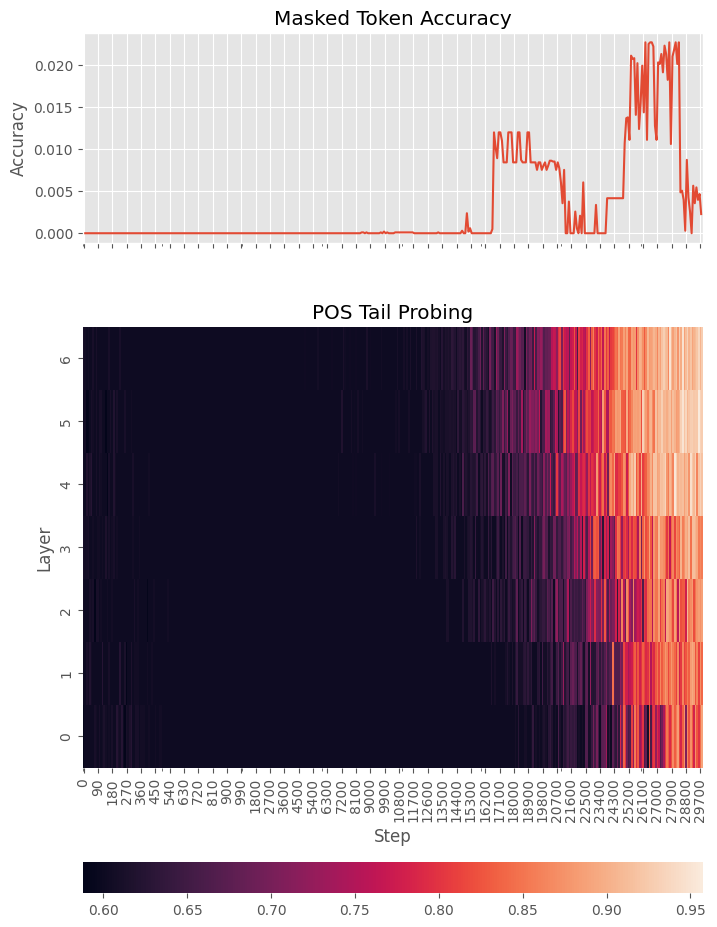

In [83]:
import matplotlib.gridspec as gridspec

df = pd.read_csv('../../outputs/toy_model/zipf-layer_6-vs_1000-a_1.5/hist_tail.csv')
acc = df[df['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
# Creating a figure
fig = plt.figure(figsize=(8, 12))

# Define the grid layout
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])

# Creating subplots in the specified grid
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# First subplot (narrower)
acc.iloc[0].plot(ax=ax1)
ax1.set_title("Masked Token Accuracy")
ax1.set_xlabel("Step")
ax1.set_ylabel("Accuracy")

# Second subplot (wider)
df = pd.read_csv('../../outputs/toy_model/zipf-layer_6-vs_1000-a_1.5/pos_probing_tail_results.csv')
df.index = df['Unnamed: 0']
df = df.drop('Unnamed: 0', axis=1)
sns.heatmap(df, ax=ax2, annot=False, cbar_kws={'orientation': 'horizontal'})

ax2.set_xlabel("Step")
ax2.set_ylabel("Layer")
ax2.set_title("POS Tail Probing")
plt.show()

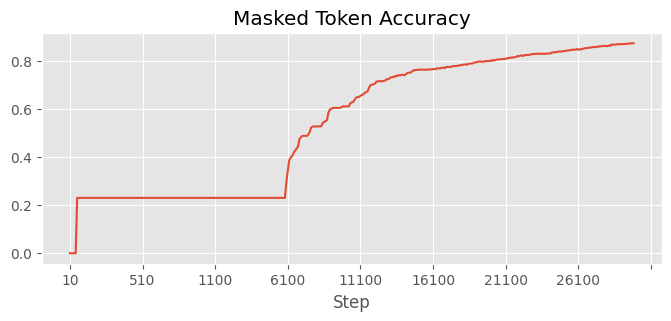

In [98]:
df = pd.read_csv('../../outputs/toy_model/zipf-layer_6-vs_10000-a_1.5/hist.csv')
acc = df[df['Unnamed: 0'] == 'acc'].drop('Unnamed: 0', axis=1)
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
acc.iloc[0].plot(ax=ax)

ax.set_xlabel("Step")
ax.set_title("Masked Token Accuracy")
plt.show()

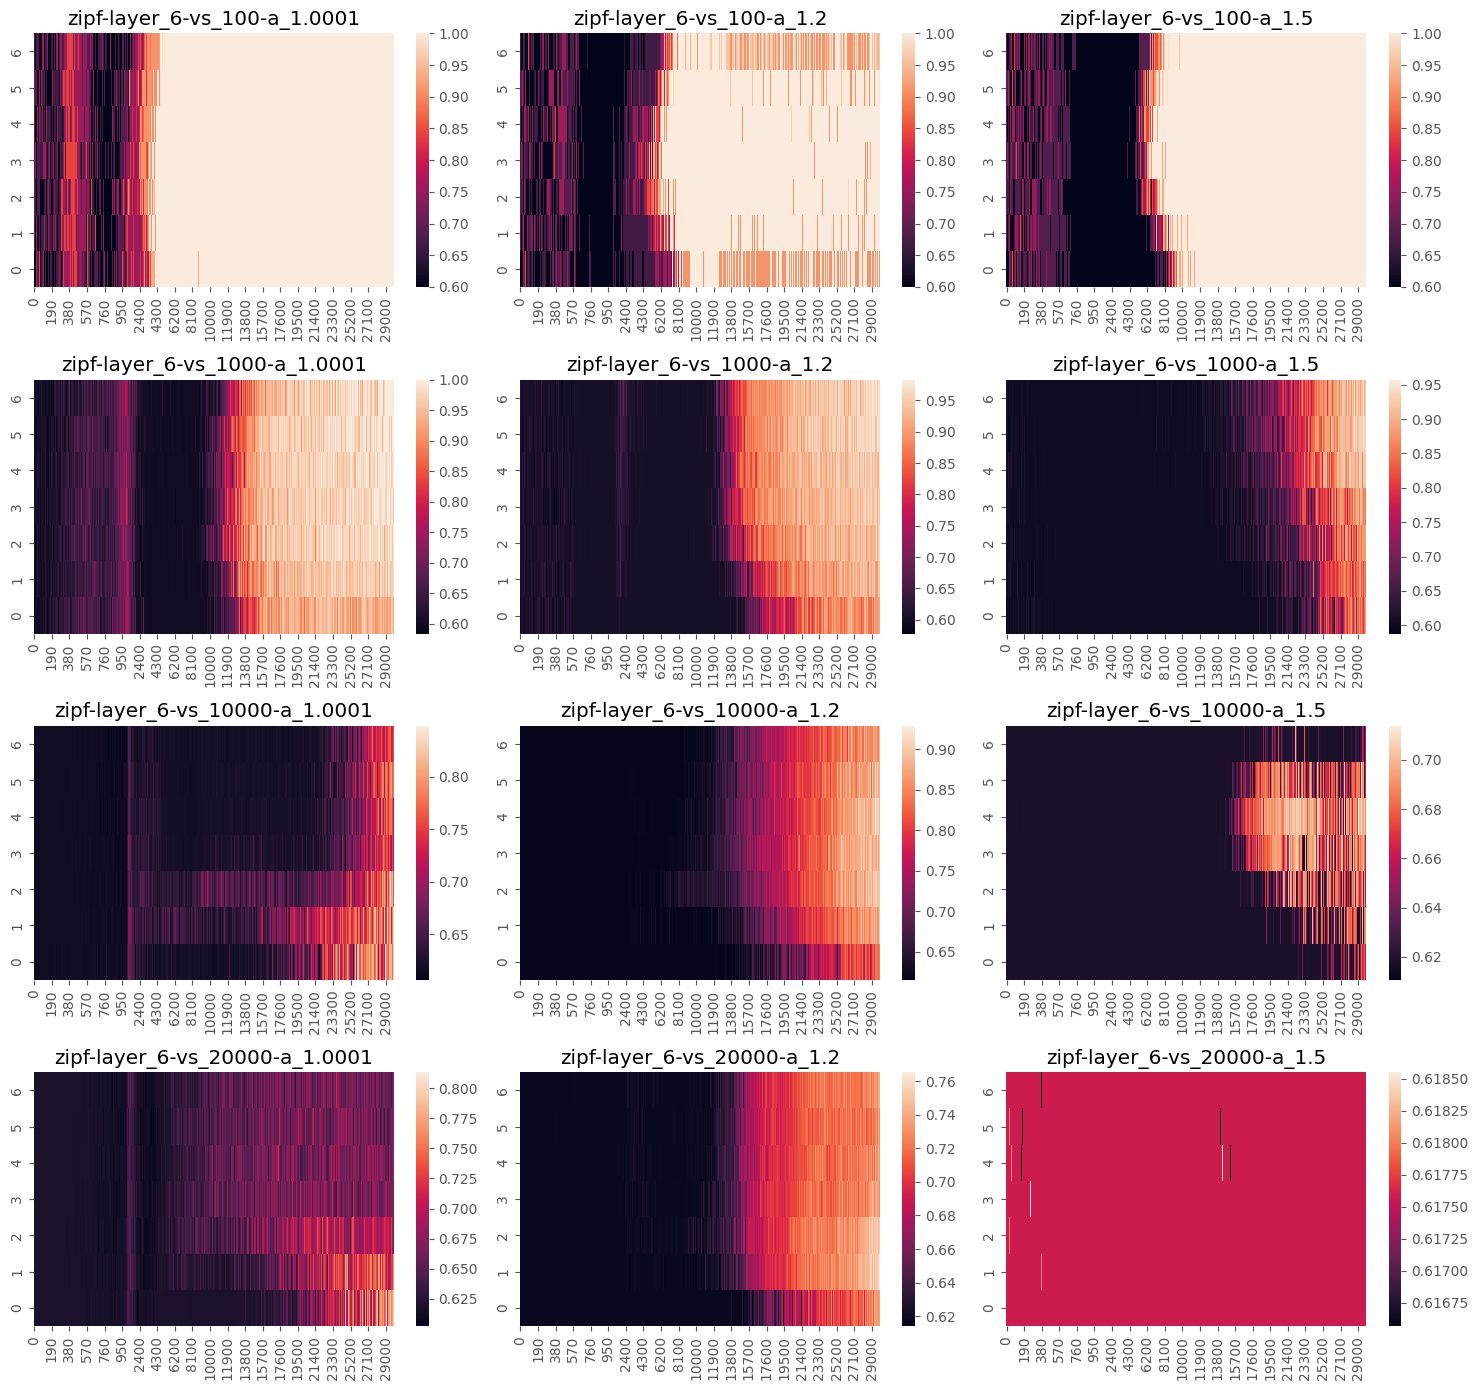

In [89]:
root_directory = '../../outputs/toy_model/'
csv_files = []
for root, dirs, files in os.walk(root_directory):
    if os.path.basename(root).startswith('zipf-'):
        for file in files:
            if file.endswith('probing_tail_results.csv') and 'old' not in root and 'old_params' not in root:
                csv_files.append(os.path.join(root, file))

# csv_files = [f for f in csv_files if '100-' not in f] ## remove 100- files
nrows = len(csv_files) // 3 + (len(csv_files) % 3 > 0)
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3.5 * nrows))
fig.tight_layout(pad=5.0)
vmax = vmin = None

for file in csv_files:
    df = pd.read_csv(file)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    vmax = max(df.max().max(), vmax) if vmax is not None else df.max().max()
    vmin = min(df.min().min(), vmin) if vmin is not None else df.min().min()

for i, file in enumerate(csv_files):
    df = pd.read_csv(file)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    df.index = df.index[::-1]
    # df = df[[str(x) for x in list(range(8000, 28000, 1000))]]
    ax = axes[i // ncols, i % ncols]
    sns.heatmap(df, ax=ax) #vmin=vmin, vmax=vmax, cbar=i == len(csv_files) - 1)
    # print(file)
    ax.set_title(file.split('/')[4].replace('unif-', ''))  # Set subtitle as file name (without extension)

for j in range(i + 1, nrows * ncols):
    axes[j // ncols, j % ncols].axis('off')
plt.tight_layout()

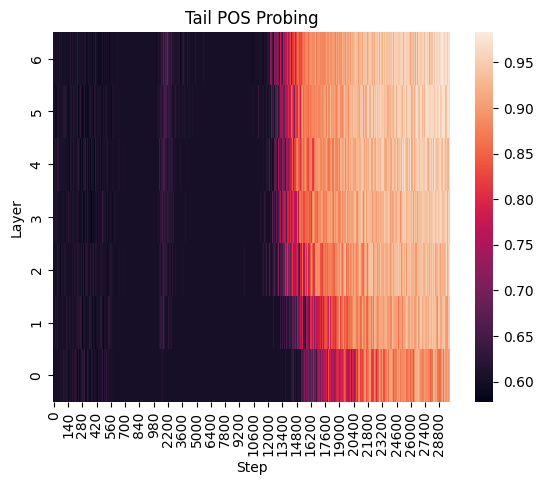

In [35]:
# df = df[::-1]
df = pd.read_csv('../../outputs/toy_model/zipf-layer_6-vs_1000-a_1.2/pos_probing_tail_results.csv')
df.index = df['Unnamed: 0']
df = df.drop('Unnamed: 0', axis=1)
ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("Tail POS Probing")
plt.show()
# plt.savefig(os.path.join(output_dir, 'pos_probing_steps.png'))


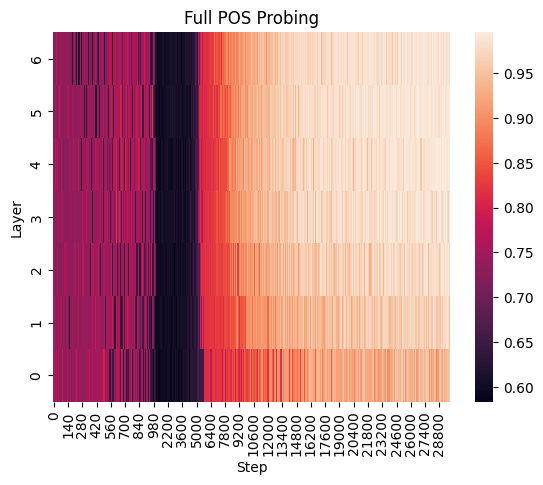

In [37]:
# df = df[::-1]
df = pd.read_csv('../../outputs/toy_model/zipf-layer_6-vs_1000-a_1.2/pos_probing_results.csv')
df.index = df['Unnamed: 0']
df = df.drop('Unnamed: 0', axis=1)
ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("Full POS Probing")
plt.show()
# plt.savefig(os.path.join(output_dir, 'pos_probing_steps.png'))


In [14]:
df = pd.read_csv('../../outputs/toy_model/old_params/zipf-layer_6-vs_10000-a_1.0001/pos_probing_results.csv').drop('Unnamed: 0', axis=1)

In [19]:
df

,0,10,20,30,40,50,60,70,80,90,...,6900,7000,7100,7200,7300,7400,7500,7600,7700,7800
0,0.591270,0.605655,0.586310,0.610615,0.603671,0.588294,0.600694,0.598710,0.585317,0.610615,...,0.544643,0.557540,0.583829,0.547619,0.566964,0.548115,0.558036,0.582341,0.604167,0.581349
1,0.595238,0.592262,0.575397,0.594742,0.609127,0.595734,0.593750,0.594246,0.599702,0.604167,...,0.560516,0.590774,0.591270,0.597718,0.599206,0.613591,0.611111,0.604663,0.602183,0.628472
2,0.613095,0.600694,0.607639,0.598214,0.586806,0.579861,0.589286,0.603671,0.601190,0.604663,...,0.597222,0.615575,0.614087,0.598710,0.603671,0.607143,0.614087,0.617063,0.625496,0.630456
3,0.611607,0.602183,0.593750,0.594246,0.607639,0.605159,0.603671,0.600198,0.598214,0.598214,...,0.609127,0.622520,0.616071,0.611607,0.609623,0.612599,0.626488,0.620040,0.633929,0.630952
4,0.610615,0.591766,0.609623,0.592758,0.597222,0.606647,0.580853,0.604663,0.595734,0.607639,...,0.585813,0.600198,0.599206,0.606151,0.622024,0.616567,0.611607,0.635417,0.618056,0.635417
5,0.584821,0.587302,0.607639,0.597718,0.592262,0.601687,0.585813,0.600198,0.594742,0.600198,...,0.610119,0.608135,0.629960,0.606151,0.627480,0.629960,0.641865,0.630952,0.628472,0.631944
6,0.592758,0.616567,0.592262,0.612103,0.589782,0.608135,0.605655,0.599206,0.601687,0.605159,...,0.607639,0.605655,0.617560,0.611111,0.607639,0.628472,0.621528,0.620536,0.643353,0.616567


In [15]:
step_eval = list(range(0, 1000, 10)) + list(range(1000, 16000, 100))
df.columns = step_eval[:len(df.columns)]

In [26]:
df_sub = df[list(range(5000, 7900, 100))]

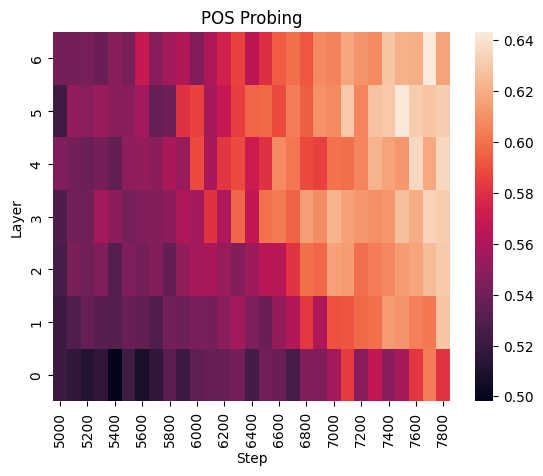

In [27]:
df_sub = df_sub[::-1]
ax = sns.heatmap(df_sub, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.show()
# plt.savefig(os.path.join(output_dir, 'pos_probing_steps.png'))


In [4]:
pythia = AutoModel.from_pretrained('EleutherAI/pythia-160m')
bert = AutoModel.from_pretrained('google/multiberts-seed_0-step_0k')

In [5]:
from collections import defaultdict
import logging
from typing import cast, Dict, List, Tuple, Union
from typing_extensions import get_args, Literal
import sys
import os
import numpy as np
import random 
import seaborn as sns
from PIL import Image
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

import yaml
import argparse
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial

from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


from transformer_lens import HookedTransformer
from transformer_lens.utils import is_square
from transformer_lens.head_detector import (compute_head_attention_similarity_score, 
                      get_previous_token_head_detection_pattern, 
                      get_duplicate_token_head_detection_pattern,
                      get_induction_head_detection_pattern)



sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments/utils')
sys.path.append('/users/sanand14/data/sanand14/learning_dynamics/src/experiments')

from aheads import create_repeats_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import BertConfig, BertForMaskedLM, AdamW


#### Make Deterministic Plz

In [6]:
class Probe(nn.Module):
    def __init__(self, num_features: int):
        super().__init__()
        self.body = nn.Linear(num_features, 1, bias=False)

    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        return self.body(x)
        
def bin_step(model, batch):
    x, y = batch
    logits = model.forward(x)
    loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
    acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
    return loss, {"loss": loss.item(), "acc": acc.item()}

def bin_train_loop(model, train_dataloader, test_dataloader, optimizer, epochs):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            model.train()
            optimizer.zero_grad()
            loss, stats = bin_step(model, batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(**stats)
            
        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            results = bin_val_loop(model, test_dataloader)
    return results

def bin_val_loop(model, test_dataloader):
    model.eval()
    acc, losses = [], []
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        for val_batch in pbar:
            loss, stats = bin_step(model, val_batch)
            acc.append(stats["acc"])
            losses.append(stats["loss"])
            results = {"acc": np.mean(acc), "loss": np.mean(losses)}
            pbar.set_postfix(**results)
    return results

In [31]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

## BERT VOCAB MODEL

### Task POS

In [32]:
num_pos_tokens = 100
assert num_pos_tokens % 2 == 0, "Has to be even"

special_token_dict_pos = {
    'cop': num_pos_tokens,
    'null': num_pos_tokens+1,
    'mask': num_pos_tokens+2
}
noun_tokens = range(num_pos_tokens//2)
adj_tokens = range(num_pos_tokens//2, num_pos_tokens)

def uniform(type='noun'):
    assert type in ['noun', 'adj'], "type not found"
    return random.choice(noun_tokens) if type == 'noun' else random.choice(adj_tokens)

def zipfian(type='noun', a=1.5):
    assert type in ['noun', 'adj'], "type not found"
    if type == 'noun':
        map = {k:v for k,v in zip(range(len(noun_tokens)), noun_tokens)}
    else:
        map = {k:v for k,v in zip(range(len(adj_tokens)), adj_tokens)}    
    value = np.random.zipf(a)
    while value not in map.keys():
        value = np.random.zipf(a)
    return map[value]

def create_dataset_task_pos(num_examples, mask_probability=0.15, masking='train', sample_func=zipfian):
    dataset = []
    labels = []
    alt_labels = []
    for _ in range(num_examples):
        rand_val = random.random()
        if rand_val < 0.40:
            noun = sample_func('noun')
            seq = [special_token_dict_pos['cop'], special_token_dict_pos['null'], noun]
            if rand_val < 0.20:
                adj = random.choice(adj_tokens)
                seq.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, special_token_dict_pos['null'], noun, noun])
            seq_alt = seq.copy()
              
        elif rand_val < 0.80: 
            noun = sample_func('noun')
            seq = [noun, special_token_dict_pos['cop'], special_token_dict_pos['null']]
            if rand_val < 0.60:
                adj = random.choice(adj_tokens)
                seq.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, special_token_dict_pos['null'], noun, noun])
            seq_alt = seq.copy()

        elif rand_val < 0.90: 
            adj, noun = sample_func('adj'), sample_func('noun')
            seq = [special_token_dict_pos['cop'], adj, noun]
            seq_alt = seq.copy()
            if rand_val < 0.85:
                seq.extend([adj, adj, adj, adj])
                seq_alt.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, adj, noun, noun])
                seq_alt.extend([noun, special_token_dict_pos['null'], noun, noun])
                
        else:
            adj, noun = sample_func('adj'), sample_func('noun')
            seq = [noun, special_token_dict_pos['cop'], adj]
            seq_alt = seq.copy()
            if rand_val < 0.95:
                seq.extend([adj, adj, adj, adj])
                seq_alt.extend([adj, special_token_dict_pos['null'], special_token_dict_pos['null'], special_token_dict_pos['null']])
            else:
                seq.extend([noun, adj, noun, noun])
                seq_alt.extend([noun, special_token_dict_pos['null'], noun, noun])

        label_seq = seq.copy()
        alt_labels_seq = seq_alt.copy()
        
        if masking=='train':
            for i in range(len(seq)):
                if random.random() < mask_probability:
                    seq[i] = special_token_dict_pos['mask']
                else:
                    label_seq[i] = -100 # ignore in loss fxn
                    alt_labels_seq[i] = -100
        else:
            for i in range(len(seq)):
                if i >= len(seq) - 3:
                    seq[i] = special_token_dict_pos['mask']
                else:
                    label_seq[i] = -100
                    alt_labels_seq[i] = -100
        dataset.append(seq)
        labels.append(label_seq)
        alt_labels.append(alt_labels_seq)

    return dataset, labels, alt_labels

In [33]:
ns1 = [zipfian('noun') for _ in range(1000)]

In [29]:
ns = [zipfian('noun') for _ in range(1000)]

(array([740.,  91.,  48.,  36.,  32.,  19.,  11.,  10.,   7.,   6.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <BarContainer object of 10 artists>)

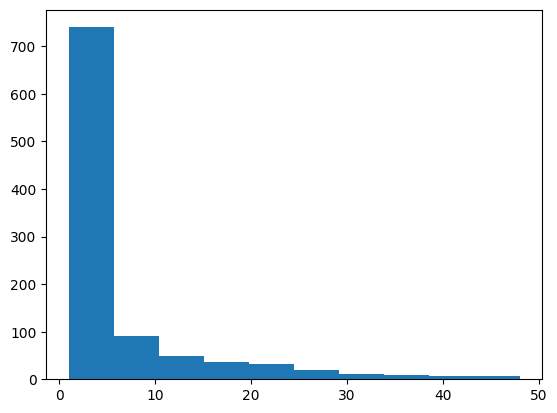

In [30]:
plt.hist(ns)

### Task DEP

In [9]:
special_token_dict_dep = {
    'mask': 400
}
seq_tokens = range(0, 400)
example_len = 20

## try + make harder 
## even smaller w the model

def generate_sequence(length, start_value, step_probability):
    sequence = [start_value]
    current_value = start_value

    for _ in range(length - 1):
        if random.random() < step_probability:
            # Change the value with the defined step change
            current_value += 1
        sequence.append(current_value)
    return sequence
    
def create_dataset_task_dep(num_examples, mask_probability=0.15, masking='train', elastic=True, step_prob = 0.90):
    assert example_len % 2 == 0, "example len must be even"
    seq_len = example_len // 2
    
    dataset = []
    labels = []
    alt_labels = []
    for _ in range(num_examples):
        rand_val = random.random()
        start_index = random.randint(0, len(seq_tokens) - seq_len)
        if elastic:
            seq = generate_sequence(seq_len, seq_tokens[start_index], step_prob) ## can have repeats
        else:
            seq = list(seq_tokens[start_index:start_index + seq_len])
        
        if rand_val < 0.80:
            seq *= 2
            seq_alt = seq.copy()
        else:
            if elastic: 
                change_ind = random.choice(range(2, seq_len+1))
                seq[-change_ind+1], seq[-change_ind] = seq[-change_ind], seq[-change_ind+1]
                seq *= 2
                seq_alt = seq.copy()
                seq[-change_ind+1] = seq[-change_ind]
            else:
                seq[-1], seq[-2] = seq[-2], seq[-1]
                seq *= 2
                seq_alt = seq.copy()
                seq[-1] = seq[-2]

        label_seq = seq.copy()
        alt_labels_seq = seq_alt.copy()
        
        if masking=='train':
            for i in range(len(seq)):
                if random.random() < mask_probability:
                    seq[i] = special_token_dict_dep['mask']
                else:
                    label_seq[i] = -100 # ignore in loss fxn
                    alt_labels_seq[i] = -100
        else:
            for i in range(len(seq)):
                if i >= len(seq) - seq_len:
                    seq[i] = special_token_dict_dep['mask']
                else:
                    label_seq[i] = -100
                    alt_labels_seq[i] = -100
        dataset.append(seq)
        labels.append(label_seq)
        alt_labels.append(alt_labels_seq)
        
    return dataset, labels, alt_labels

### Dataloader Helper

In [10]:
def create_dataloaders(num_train, num_val, device="cpu", task=create_dataset_task_pos):
    inputs_t, labels_t, alt_labels_t = task(num_train, mask_probability=0.15, masking='test')
    inputs_v, labels_v, alt_labels_v = task(num_val, mask_probability=0, masking='test')
    
    inputs_t = torch.tensor(inputs_t).to(device)
    labels_t = torch.tensor(labels_t).to(device)
    alt_labels_t = torch.tensor(alt_labels_t).to(device)
    inputs_v = torch.tensor(inputs_v).to(device)
    labels_v = torch.tensor(labels_v).to(device)
    alt_labels_v = torch.tensor(alt_labels_v).to(device)

    train_dataset = TensorDataset(inputs_t.detach(), labels_t, alt_labels_t)
    val_dataset = TensorDataset(inputs_v.detach(), labels_v, alt_labels_v)
    
    train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    return train_dataloader, val_dataloader

def create_dataloaders_bin(data, labels, device="cpu"):
    train_len = int(0.80 * len(data))
    inputs_t, labels_t = data[:train_len], labels[:train_len]
    inputs_v, labels_v = data[train_len:], labels[train_len:]
    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    return train_dataloader, val_dataloader


### Training BERT Helpers

In [11]:
def pca_pos(model, val_dataloader, title, c_step, probe_results=defaultdict(list)):
    labels, hidden_layers = [], defaultdict(list)
    model.config.output_hidden_states=True
    num_hidden_states = model.config.num_hidden_layers + 1
    fig, axs = plt.subplots(1, num_hidden_states, figsize=(5*num_hidden_states, 5))
    
    for batch in val_dataloader:
        examples, _, _ = batch
        labels.append((examples[:, -4] < 50).float())
        with torch.no_grad():
            outputs = model(examples.to(device))
        for j in range(num_hidden_states):
            hidden_layers[j].append(outputs.hidden_states[j][:, -4, :])
    
    labels = torch.concat(labels, axis=0).unsqueeze(1)
    for i in range(num_hidden_states):
        torch_embed = torch.concat(hidden_layers[i], axis=0).squeeze()
        probe = Probe(torch_embed.shape[1]).to(model.device)
        train_dataloader_bin, val_dataloader_bin = create_dataloaders_bin(torch_embed, labels, device=model.device)
        optim_bin = torch.optim.AdamW(probe.parameters(), lr=1e-3) 
        
        results = bin_train_loop(probe, train_dataloader_bin, val_dataloader_bin, optim_bin, 3)
        probe_results[i].append(results['acc'])

        labels_numpy = labels.cpu().numpy().squeeze()
        np_embed = torch_embed.cpu().numpy()
        
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(np_embed)
        
        unique_labels = np.unique(labels_numpy)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))
        
        for j, label in enumerate(unique_labels):
            axs[i].scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                        alpha=0.5, color=colors(j), label=f"Label {label}")
        
        axs[i].set_title(f"state {i} acc={results['acc']:0.2f}")
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")
        axs[i].legend()
        axs[i].grid(True)
                
    plt.suptitle(title)
    # plt.savefig(f'images/pca_step_{c_step}.png')
    # plt.show()
    plt.close()
    
    return probe_results

In [12]:
def step(model, batch, hard_acc=False):
    x, y, alt_y = batch
    output = model.forward(x)
    logits = output.logits.transpose(1, 2)
    loss = criterion(logits, y)
    batch_len = logits.shape[0]

    where = (y != -100)
    y, alt_y = y[where].view(batch_len, -1), alt_y[where].view(batch_len, -1)
    
    preds = logits.argmax(axis=1)[where].view(batch_len, -1)
    
    ## full examples where alt != alt_label
    batch_same = (y == alt_y).all(axis=-1)
    if hard_acc:
        acc = (preds == y).all(axis=-1).float().mean() 
        alt_acc = (preds == alt_y).all(axis=-1).float().mean()
    else:
        acc = (preds == y)[~batch_same].float().mean() 
        alt_acc = (preds == alt_y)[~batch_same].float().mean()
    
    return loss, {"loss": loss.item(), "acc": acc.item(), "alt_acc": alt_acc.item()}

def train_loop(model, train_dataloader, test_dataloader, optimizer, epochs, step_eval=1000, name=None, pca=True):
    pbar = tqdm(range(epochs))
    val_stats = {}
    hist = {}
    c_step = 0
    probe_results = defaultdict(list)
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            c_step += 1
            model.train()
            optimizer.zero_grad()
            loss, stats = step(model, batch, hard_acc=True)
            loss.backward()
            optimizer.step()
            stats.update(val_stats)
            pbar.set_postfix(**stats)
            if isinstance(step_eval, int):
                if c_step % step_eval == 0:
                    hist[c_step] = val_loop(model, test_dataloader)
                    if pca:
                        probe_results = pca_pos(model, test_dataloader, f'Step {c_step}', c_step, probe_results)
                    if name is not None:
                        torch.save(model.state_dict(), f'models/{name}_step_{c_step}.pth')
            elif isinstance(step_eval, list):
                if c_step in step_eval:
                    hist[c_step] = val_loop(model, test_dataloader)
                    if pca:
                        probe_results = pca_pos(model, test_dataloader, f'Step {c_step}', c_step, probe_results)
                    if name is not None:
                        torch.save(model.state_dict(), f'models/{name}_step_{c_step}.pth')
            else:
                raise ValueError('Not recognized format for step')
                
                
        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            val_stats = val_loop(model, test_dataloader)
            val_stats = {"val_" + key:val for key,val in val_stats.items()}
            pbar.set_postfix(**val_stats)
    return hist, probe_results
                
def val_loop(model, test_dataloader):
    model.eval()
    acc, acc_alt, losses = [], [], []
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        for val_batch in pbar:
            loss, stats = step(model, val_batch, hard_acc=True)
            acc.append(stats["acc"])
            acc_alt.append(stats["alt_acc"])
            losses.append(stats["loss"])
            results = {"acc": np.mean(acc), "alt_acc": np.mean(acc_alt), "loss": np.mean(losses)}
            pbar.set_postfix(**results)
    return results

### POS Experiment

In [14]:
num_epochs = 1
device = "cuda:0" if torch.cuda.is_available() else "cpu"
task=create_dataset_task_pos

In [15]:
config = BertConfig(
    vocab_size=103 if task==create_dataset_task_pos else 401,
    hidden_size=16, # 128  
    num_hidden_layers=8,  
    num_attention_heads=2, # 8
    intermediate_size=32 # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5) 
criterion = nn.CrossEntropyLoss()

In [16]:
max_num_steps = 1_000_000 * 5 /128

In [17]:
train_dataloader, val_dataloader = create_dataloaders(10_000, 10_000, device=device, task=task)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_2893833/2066092094.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

{'acc': 0.0, 'alt_acc': 0.0, 'loss': 4.422953032240083}


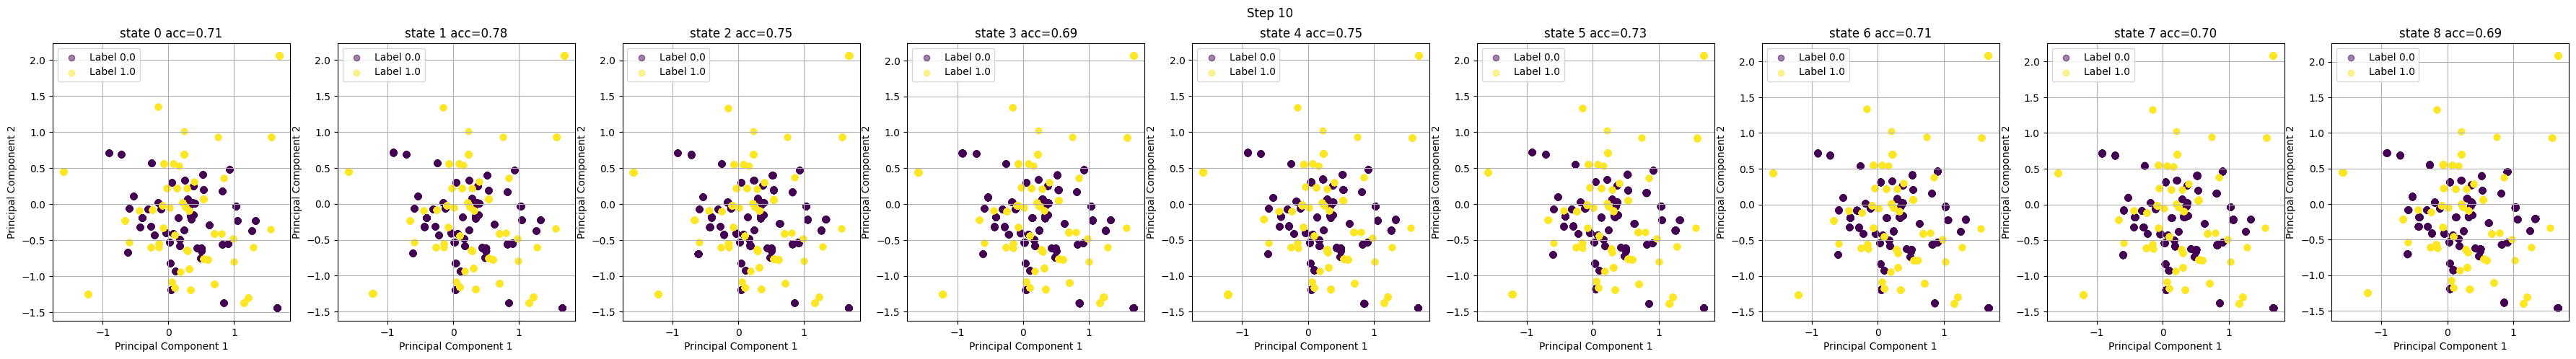

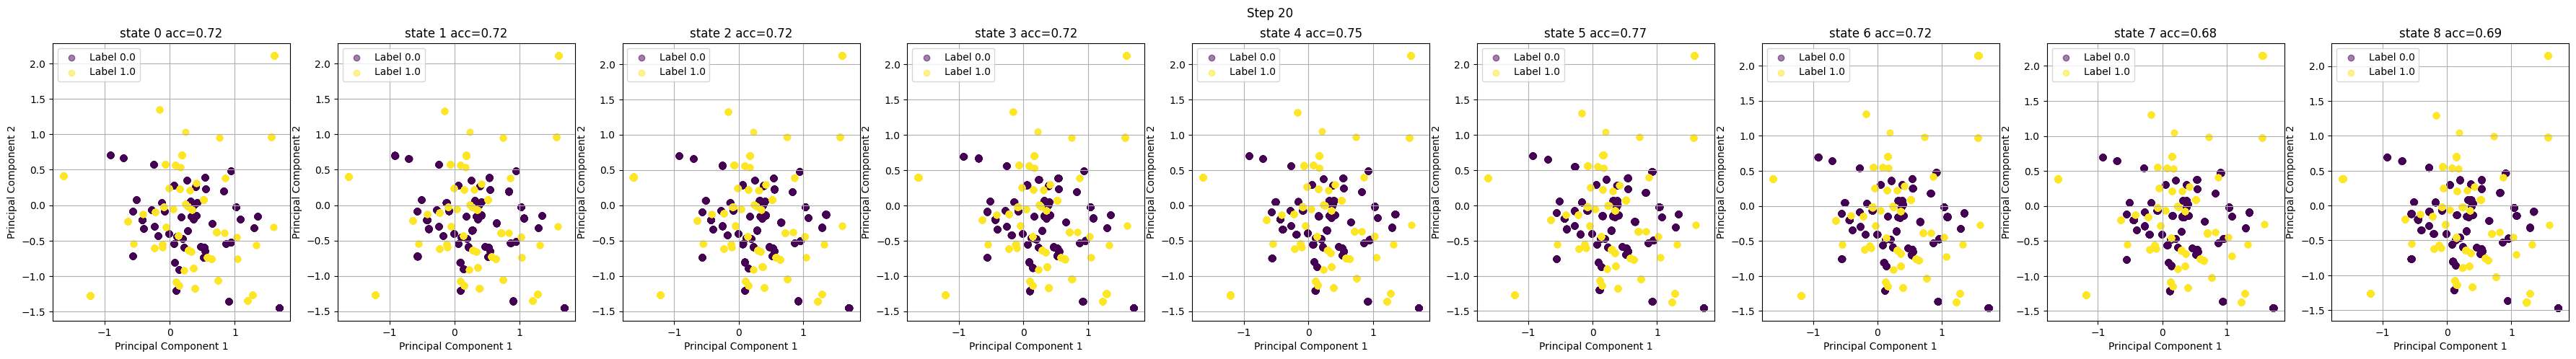

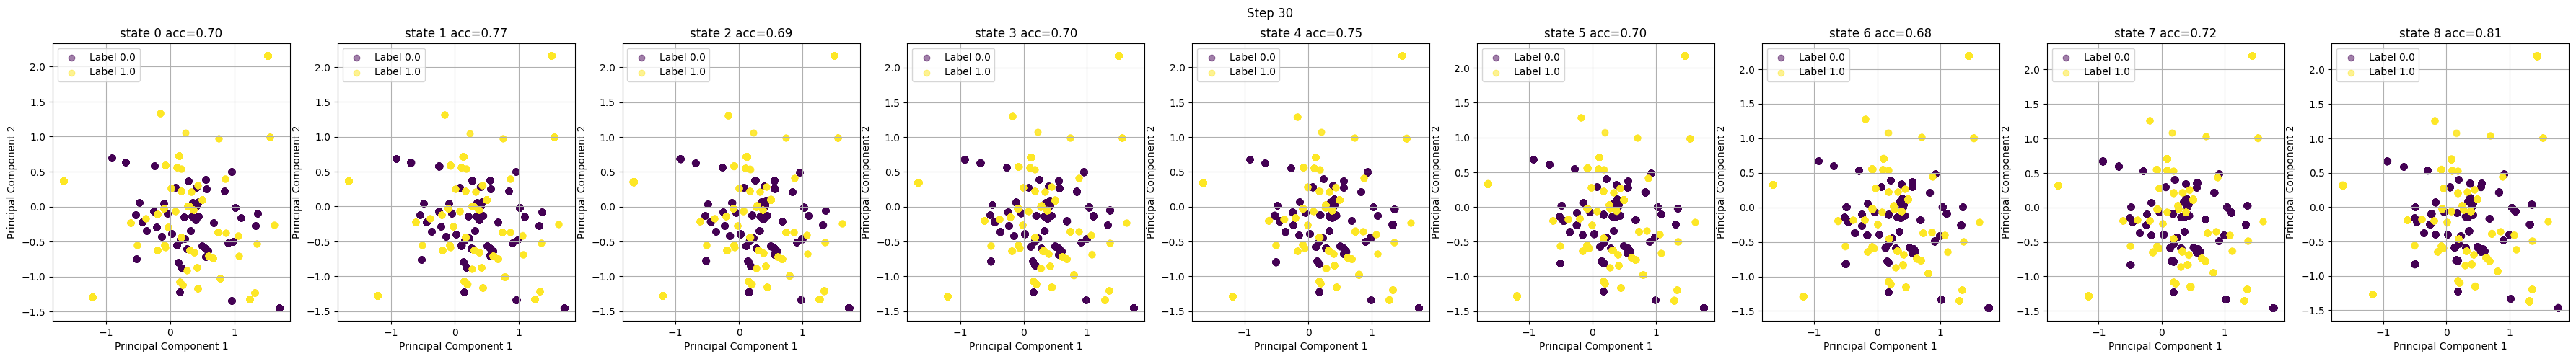

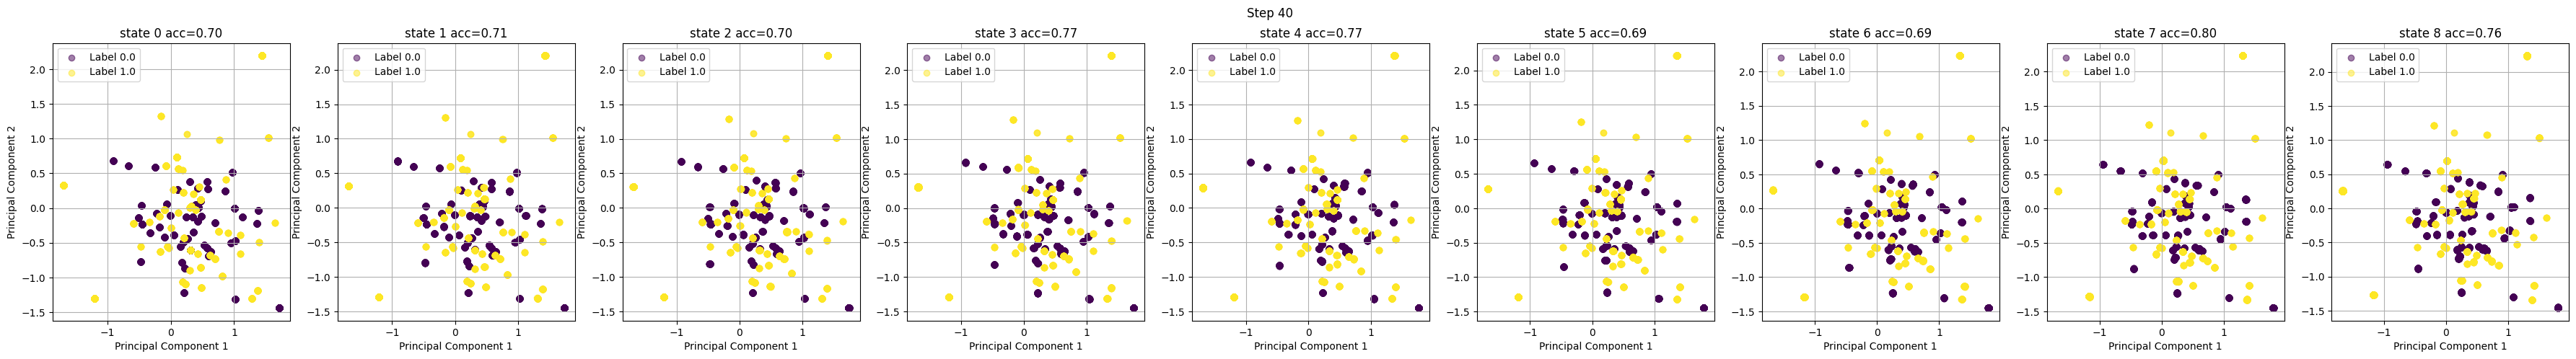

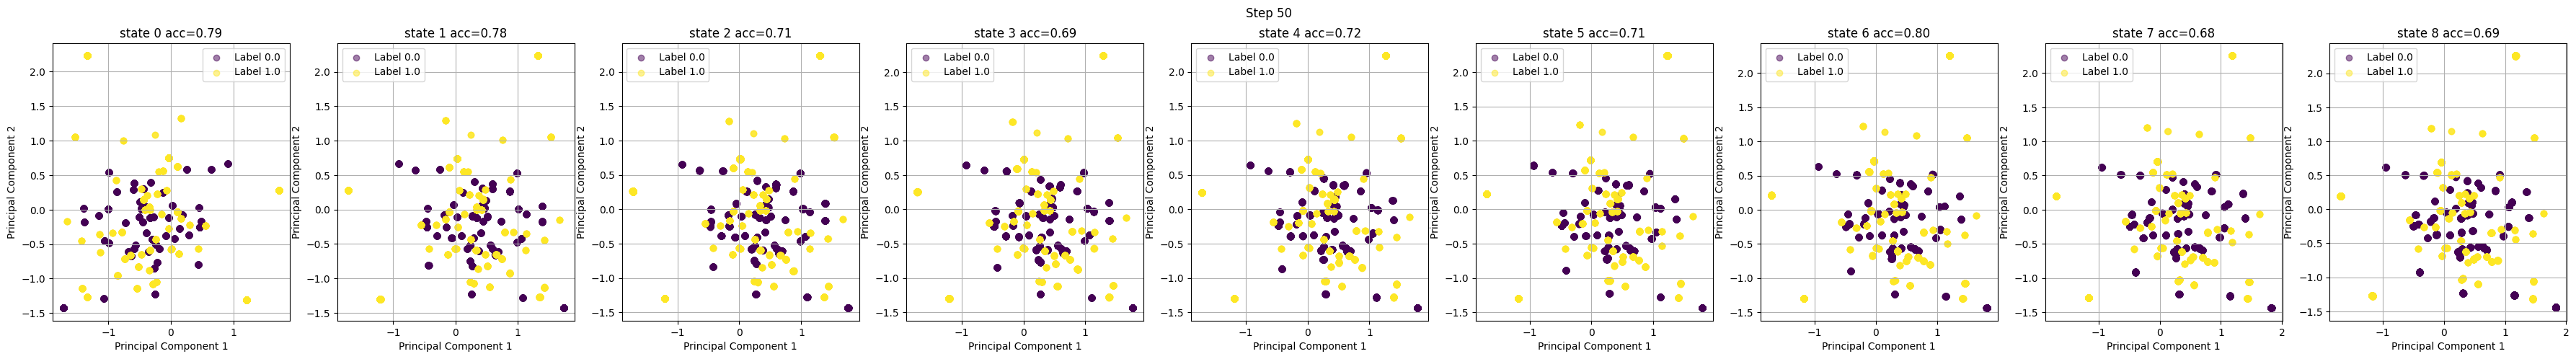

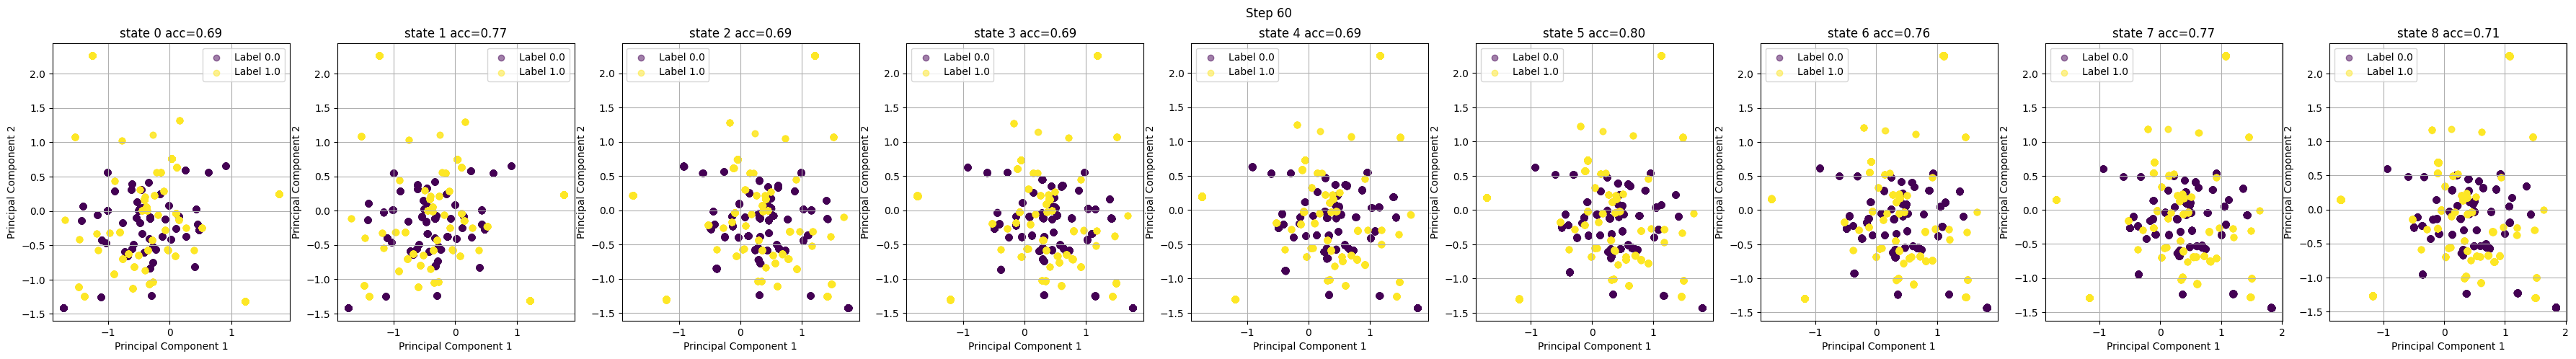

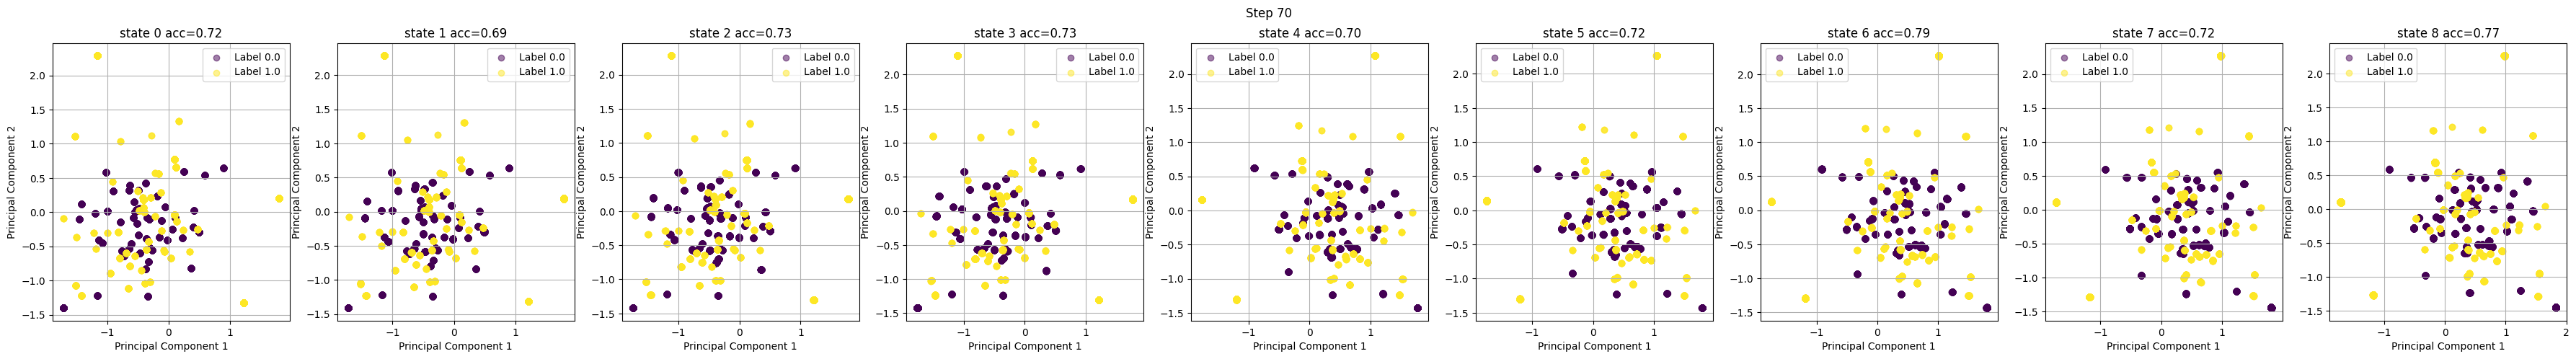

In [18]:
#step_eval = [10, 100, 200, 400, 800, 1000, 2000, 4000, 10000, 38000, 70000]
step_eval = list(range(0, 1000, 10))
hist, probing_results = train_loop(toy_bert_model, train_dataloader, val_dataloader, 
                                   optimizer, num_epochs, 
                                   step_eval=step_eval, name=None)#'pos_model')
val_stats = val_loop(toy_bert_model, val_dataloader)
print(val_stats) # 10 - 80 identical, 10 - 20 1 token 
## make accuracy measurement an all

## pos looks like it is doing alt first actually
## between 4 and 5 epochs looks like strategy changes

In [23]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:len(df)-2]

df = df[::-1]

In [28]:
pd.DataFrame(hist)

,10,20,30,40,50,60,70
acc,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
alt_acc,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
loss,4.593277,4.563362,4.534465,4.507429,4.48288,4.460462,4.440004


In [ ]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing_1000steps.png')

plt.show()


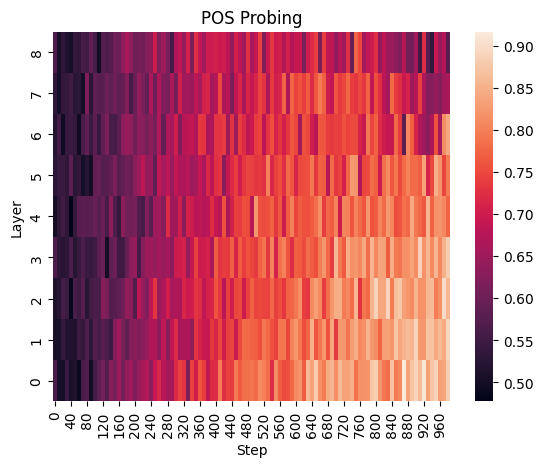

In [66]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=False)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing_1000steps.png')

plt.show()


In [64]:
def sort_key(filename):
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0
    
folder_path = '2-layer/images'
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
image_files.sort(key=sort_key)
fig, axs = plt.subplots(len(image_files), 1, figsize=(10, len(image_files) * 5))

if not isinstance(axs, np.ndarray):
    axs = [axs]

for ax, img_file in zip(axs, image_files):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off') 

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '2-layer/images'

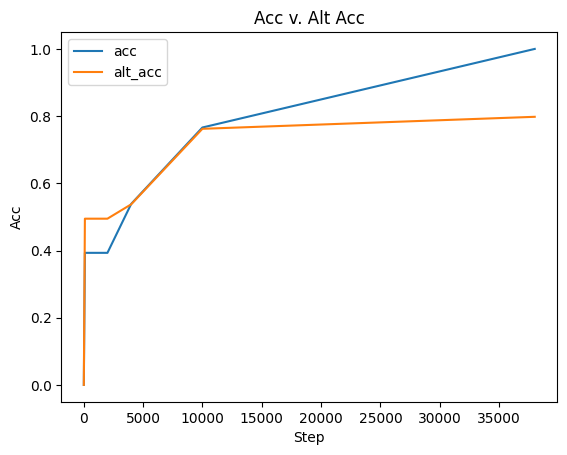

In [44]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()


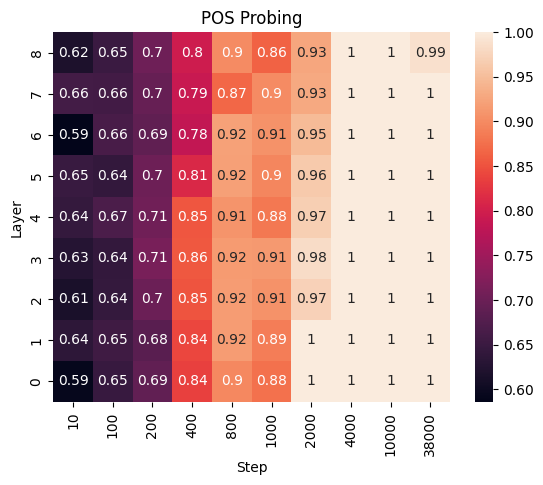

In [45]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=True)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing.png')

plt.show()


RESULTS 2 LAYER

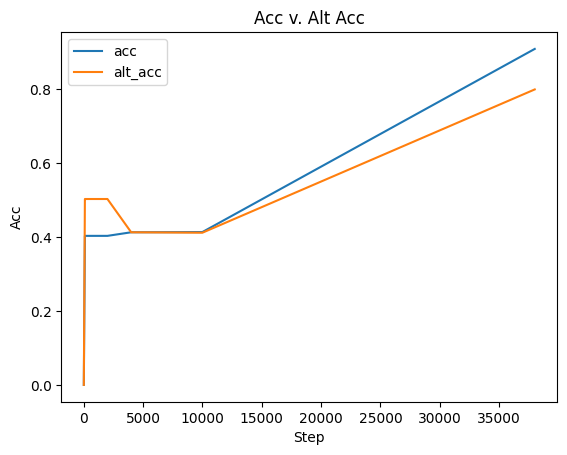

In [22]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()


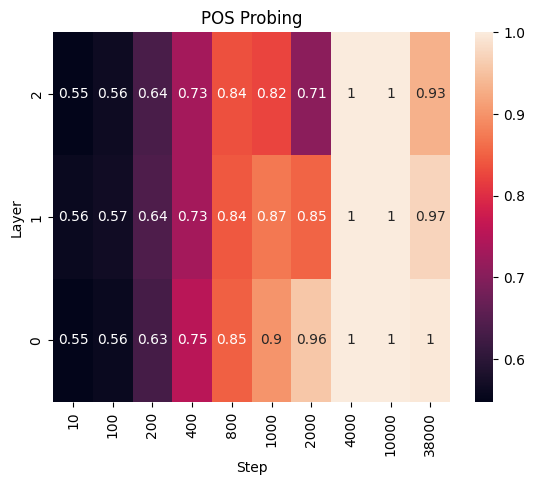

In [27]:
df = pd.DataFrame(probing_results)
df = df.transpose()
df.columns = step_eval[:-1]

df = df[::-1]

ax = sns.heatmap(df, annot=True)

ax.set_xlabel("Step")
ax.set_ylabel("Layer")
ax.set_title("POS Probing")
plt.savefig('pos_probing.png')

plt.show()


| Metric   | One Hidden Layers | Two Hidden Layers | Three Hidden Layers |
|----------|-------------------|-------------------|---------------------|
| acc      |     0.09462       | 0.09734           | 0.00019             |
| alt_acc  |     0.093527      | 0.09136           | 0.00021             |
| loss     |     0.17726       | 0.07501           | 5.99352             |


In [29]:
# dset = val_dataloader.dataset
# for i in range(100):
#     example, label, alt_label = dset.tensors[0][i], dset.tensors[1][i], dset.tensors[2][i]
#     if not torch.all(label == alt_label):
#         where = (label != -100)
#         print("PREDICTION", toy_bert_model(example.unsqueeze(dim=0)).logits.transpose(1, 2).argmax(axis=1)[where.unsqueeze(0)])
#         print("ALT_LABEL", alt_label[where])
#         print("LABEL", label[where])
#         print()

### DEP Experiment

In [30]:
num_epochs = 10
device = "cuda:0" if torch.cuda.is_available() else "cpu"
task=create_dataset_task_dep

In [31]:
config = BertConfig(
    vocab_size=103 if task==create_dataset_task_pos else 401,
    hidden_size=16, # 128  
    num_hidden_layers=2,  
    num_attention_heads=2, # 8
    intermediate_size=32 # 512
)
toy_bert_model = BertForMaskedLM(config).to(device)
optimizer = torch.optim.AdamW(toy_bert_model.parameters(), lr=5e-5) 
criterion = nn.CrossEntropyLoss()

In [32]:
max_num_steps = 1_000_000 * 5 /128

In [33]:
train_dataloader, val_dataloader = create_dataloaders(1_000_000, 10_000, device=device, task=task)

In [34]:
step_eval = [10, 100, 200, 400, 800, 1000, 2000, 4000, 10000, 38000, 70000]
hist, probing_results = train_loop(toy_bert_model, train_dataloader, val_dataloader, optimizer, num_epochs, step_eval=step_eval, name='dep_model', pca=False)
val_stats = val_loop(toy_bert_model, val_dataloader)
print(val_stats) # 10 - 80 identical, 10 - 20 1 token 
## make accuracy measurement an all

## pos looks like it is doing alt first actually
## between 4 and 5 epochs looks like strategy changes

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

{'acc': 0.5743670886075949, 'alt_acc': 0.5581487341772152, 'loss': 0.8008955264393287}


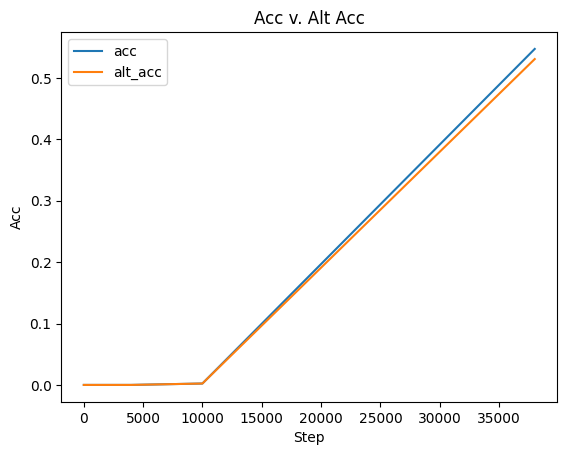

In [35]:
df_hist = pd.DataFrame(hist)
df_hist.transpose().drop('loss', axis=1).plot(kind='line')

plt.xlabel('Step')
plt.ylabel('Acc')
plt.title('Acc v. Alt Acc')
plt.show()

* Trained too few epochs but trend just continues (i.e. never adopts/gets better at alternative strategy)

* Don't know why can't get about 0.429 accuracy
* Tried increasing model width, model num hidden layers, and dataset size
* Alternative strategy accuracy looks better at only very beginning (almost no matter size)

## TOY MODEL

Notes:

1. Residual Connection is not cause
2. Happens with 2 layer (1 interm, head) as well, but separation slightly less present
3. Does not happen when freeze layer 1 in 2 layer (random projection hypothesis)
4. Does not happen when freeze layer 1 in 3 layer (2 interm w/ resid, head) -- figure out why not difference + check layer 2
5. What is happening is not pushback, but rather choosing of a strategy (i.e. fully separable l1 after pt, then simply uses that)

Other Notes:
1. Reducing std hurts, not helps final task (idk why)

In [99]:
class ToyModel(nn.Module):
    def __init__(self, num_features: int, num_interm : int):
        super().__init__()
        self.fc1 = nn.Linear(num_features, num_interm)
        # Second fully connected layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_interm, num_interm)
        self.relu2 = nn.ReLU()
        # self.fc3 = nn.Linear(num_interm, num_interm)
        # self.relu3 = nn.ReLU()
        self.head = nn.Linear(num_interm, 1, bias=False)

    def forward(self, x):
        if isinstance(x, list):
            x, _ = x
        out = self.relu1(self.fc1(x))
        out = self.relu2(self.fc2(out)) + out
        # out = self.relu3(self.fc3(out)) + out
        return self.head(out) 

* Train on disambiguated data to detect mean m1
* Train on ambiguated data to detect whole task
* Check whether inetermediate layer data is split by mean m1

### Gen Data Func

In [39]:
## generation hyperparameters

size = 10000
m1, m2, m3, m4 = 0, 0, 2, 3
s1, s2, s3, s4 = 1, 1, 1, 1 ## 1, 1, 1, 1 - dec to 0.2
N, N_p, N_pp = 0, 2, 3
vec_size = 16 ## was 4

heuristic=0.75


In [40]:
def generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
    f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
    f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
    f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = torch.normal(mean=torch.tensor(m1).repeat((1, vec_size)).float(), std=s1)
            f2 = torch.normal(mean=torch.tensor(m2).repeat((1, vec_size)).float(), std=s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
            
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = torch.normal(mean=torch.tensor(m3).repeat((1, vec_size)).float(), std=s3)
                f4 = torch.normal(mean=torch.tensor(m4).repeat((1, vec_size)).float(), std=s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp) 
    return full, label, alt_label

In [41]:
def mixture(m_a, m_b, s=0.2): 
    if random.random() > 0.5: 
        return torch.normal(mean=torch.tensor(m_a).repeat((1, vec_size)).float(), std=s)
    else: 
        return torch.normal(mean=torch.tensor(m_b).repeat((1, vec_size)).float(), std=s)
        
def generate_gaussian_mixture_inputs_w_heur(m1, s1, m2, s2, m3, s3, m4, s4, vec_size, N, N_p, N_pp, init_task=True, disamb=0.5, heuristic=None):
    f1 = mixture(m1 - 1, m1 + 1, s1)
    f2 = mixture(m2 - 1, m2 + 1, s2)
    f3 = mixture(m3 - 1, m3 + 1, s3)
    f4 = mixture(m4 - 1, m4 + 1, s4)
    f1_gt_N = (torch.mean(f1) > N)
    f2_gt_N = (torch.mean(f2) > N)
    if random.random() < disamb: ## f1 > N != f2 > N (i.e. ambiguous)
        while f1_gt_N == f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    else: ## f1 > N == f2 > N (i.e. ambiguous)
        while f1_gt_N != f2_gt_N:
            f1 = mixture(m1 - 1, m1 + 1, s1)
            f2 = mixture(m2 - 1, m2 + 1, s2)
            f1_gt_N = (torch.mean(f1) > N)
            f2_gt_N = (torch.mean(f2) > N)
    if heuristic is not None:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        if random.random() < heuristic:
            while f1_gt_N != label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        else:
            while f1_gt_N == label:
                f3 = mixture(m3 - 1, m3 + 1, s3)
                f4 = mixture(m4 - 1, m4 + 1, s4)
                label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
                
    full = torch.concat([f1, f2, f3, f4], dim=1) 
    if init_task:
        label = f1_gt_N
        alt_label = f2_gt_N
    else:
        label = (torch.mean(f3) > N_p) if f1_gt_N else (torch.mean(f4) > N_pp)
        alt_label = (torch.mean(f3) > N_p) if f2_gt_N else (torch.mean(f4) > N_pp)
    return full, label, alt_label

In [42]:
def create_dataset(init_task, disamb, size=size, heuristic=None):
    inputs = []
    labels = []
    alt_labels = []
    
    for i in tqdm(range(size)):
        input, label, alt_label = generate_gaussian_inputs(m1, s1, m2, s2, m3, s3, m4, s4, 
                                                                          vec_size, N, N_p, N_pp, 
                                                                          init_task=init_task, disamb=disamb, heuristic=heuristic)
        inputs.append(input)
        labels.append(label)
        alt_labels.append(alt_label)
        
    inputs = torch.vstack(inputs)
    labels = torch.vstack(labels).float()
    alt_labels = torch.vstack(alt_labels).float()
    
    train_size = int(0.8 * len(inputs))
    
    inputs_t, labels_t, alt_labels_t = inputs[:train_size], labels[:train_size], alt_labels[:train_size]
    inputs_v, labels_v, alt_labels_v = inputs[train_size:], labels[train_size:], alt_labels[train_size:]

    train_dataset = TensorDataset(inputs_t.detach(), labels_t.view(-1, 1))
    val_dataset = TensorDataset(inputs_v.detach(), labels_v.view(-1, 1))

    train_dataset_alt = TensorDataset(inputs_t.detach(), alt_labels_t.view(-1, 1))
    val_dataset_alt = TensorDataset(inputs_v.detach(), alt_labels_v.view(-1, 1))

    return train_dataset, val_dataset, train_dataset_alt, val_dataset_alt

### Model Params/Functions

In [44]:
## model params/hyperparams

epochs = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
interm_size = 128 ## was 128

In [45]:
def step(model, batch):
    x, y = batch
    logits = model.forward(x)
    loss = F.binary_cross_entropy(torch.sigmoid(logits), y)
    acc = ((logits.squeeze() > 0.5).float() == y.squeeze()).float().mean()
    return loss, {"loss": loss.item(), "acc": acc.item()}

def train_loop(model, train_dataloader, test_dataloader, optimizer, epochs):
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        pbar.set_description(f"Training Epoch {epoch}")
        for batch in train_dataloader:
            model.train()
            optimizer.zero_grad()
            loss, stats = step(model, batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(**stats)

        model.eval()
        with torch.no_grad():
            pbar.set_description("Validation")
            for val_batch in test_dataloader:
                loss, stats = step(model, val_batch)
                pbar.set_postfix(**stats)
                
def val_loop(model, test_dataloader):
    model.eval()
    acc, losses = [], []
    with torch.no_grad():
        for val_batch in tqdm(test_dataloader):
            loss, stats = step(model, val_batch)
            acc.append(stats["acc"])
            losses.append(stats["loss"])
    return np.mean(acc), np.mean(losses)

In [46]:
def plot_pcas(interm_train, labels_train, alt_labels_train, title="biased"):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    disamb_learn_numpy = interm_train.detach().numpy()
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(disamb_learn_numpy)
    
    for i, labels_curr in enumerate([labels_train, alt_labels_train]):
        labels_numpy = labels_curr.squeeze()
        unique_labels = np.unique(labels_numpy)
        colors = plt.cm.get_cmap('viridis', len(unique_labels))
        
        for j, label in enumerate(unique_labels):
            axs[i].scatter(data_pca[labels_numpy == label, 0], data_pca[labels_numpy == label, 1], 
                        alpha=0.5, color=colors(j), label=f"Label {label}")
        
        axs[i].set_title(f"Separation of mean(f{i+1}) > N")
        axs[i].set_xlabel("Principal Component 1")
        axs[i].set_ylabel("Principal Component 2")
        axs[i].legend()
        axs[i].grid(True)

    plt.suptitle(title)
    plt.show()

In [47]:
heuristic=None

In [48]:
toy_model = ToyModel(4*vec_size, interm_size)

# for param in toy_model.fc1.parameters():
#     param.requires_grad = False

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, toy_model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(toy_model.parameters(), lr=0.001)

### Task 1: Learn mean(f1) > N on disambiguated data 

disambiguated = where mean(f2) > N is the same label with p=0.5

In [49]:
def task1(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=True, disamb=0.5, size=10000, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
    
task1(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.97, LOSS: 0.05


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


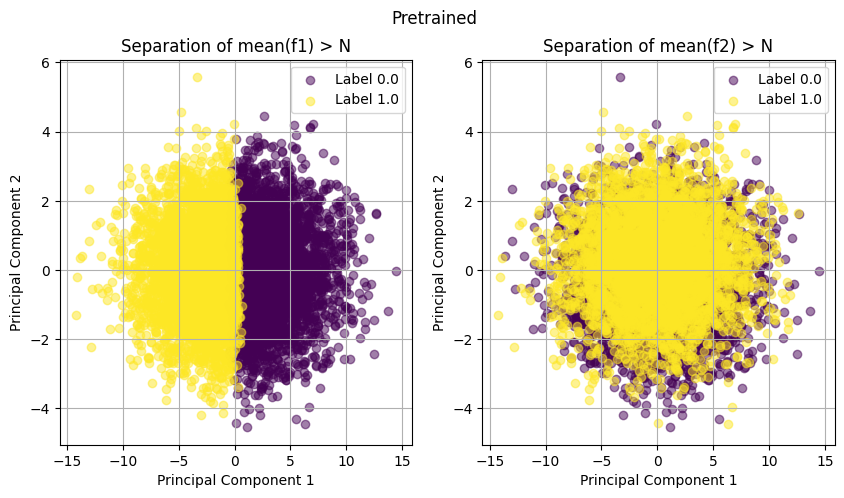

In [50]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

# interm_train_biased, interm_val_biased = layer2_biased(train_dataset.tensors[0]), layer2_biased(val_dataset.tensors[0])
# plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

interm_train_biased, interm_val_biased = layer1_biased(train_dataset.tensors[0]), layer1_biased(val_dataset.tensors[0])
plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")


### Task 2: Learn mean(f3) > N' if mean(f1) > N else mean(f4) > N'' on ambiguated data 

ambiguated = where mean(f2) > N is the same label with p=0.98

In [51]:
for param in toy_model.fc1.parameters():
    param.requires_grad = True

# new_params = [p for p in toy_model.fc1.parameters() if p.requires_grad]
# optimizer.add_param_group({'params': new_params})

In [61]:
toy_model_new = ToyModel(4*vec_size, interm_size) ## ab 75-80% baseline
optimizer_new = torch.optim.Adam(toy_model_new.parameters(), lr=0.001)
epochs=5

In [62]:
def task2(toy_model, optimizer, epochs, heuristic):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=0.50, heuristic=heuristic)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

task2(toy_model, optimizer, epochs, heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.81, LOSS: 0.42


In [63]:
task2(toy_model_new, optimizer_new, epochs, heuristic=heuristic)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.74, LOSS: 0.53


### Check: whether intermediate data is better at mean(f1) > N or mean(f2) > N on disambiguated data

In [64]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=1, heuristic=heuristic)

label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [65]:
acc, loss = val_loop(toy_model, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.81, LOSS: 0.42


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.43, LOSS: 1.48


In [66]:
acc, loss = val_loop(toy_model_new, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
acc, loss = val_loop(toy_model_new, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.73, LOSS: 0.53


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.49, LOSS: 1.05


In [25]:
layer1_biased = toy_model.fc1
# layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
# layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]
## need to be ambiguous be maximally random

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


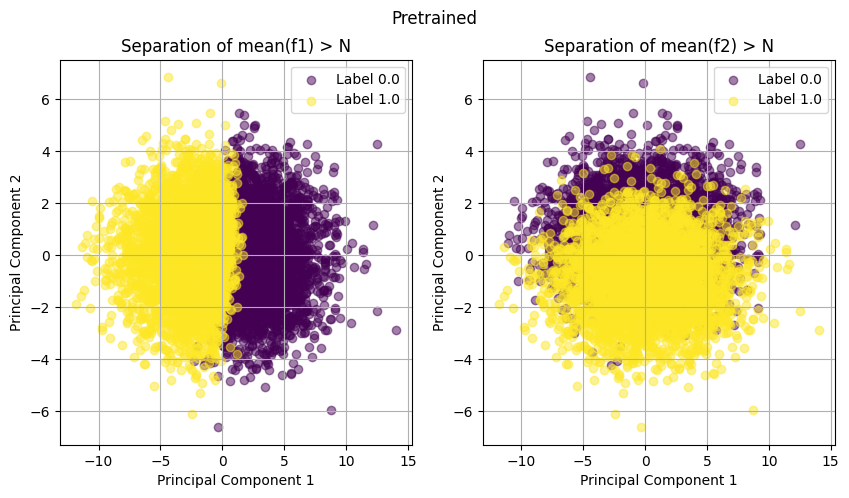

/tmp/ipykernel_1297575/3323052680.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


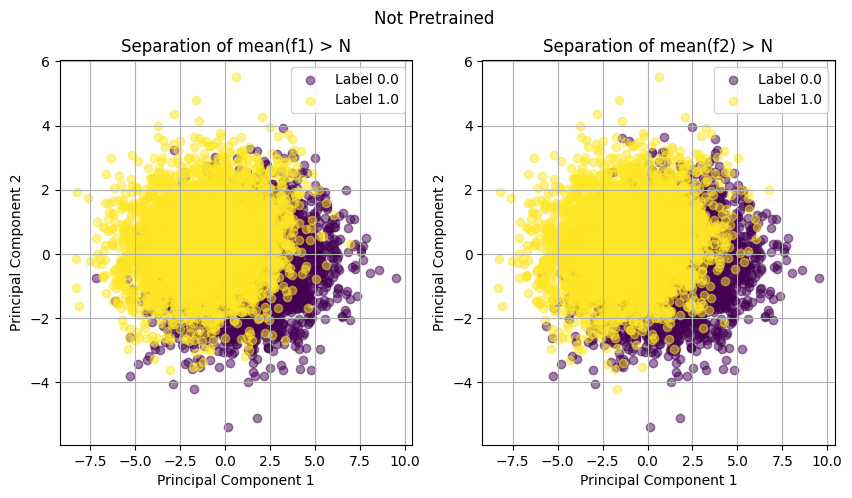

In [26]:
def layer_num_pca(layer_num):
    interm_train_biased, interm_val = eval(f'layer{layer_num}_biased(train_dataset.tensors[0]), layer{layer_num}_biased(val_dataset.tensors[0])')
    plot_pcas(interm_train_biased, labels_train, alt_labels_train, title="Pretrained")

    interm_train_control, interm_val = eval(f'layer{layer_num}_control(train_dataset.tensors[0]), layer{layer_num}_control(val_dataset.tensors[0])')
    plot_pcas(interm_train_control, labels_train, alt_labels_train, title="Not Pretrained")

layer_num_pca(1)

## Covariance Statistics Effect

In [74]:
toy_model_con = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_con = torch.optim.Adam(toy_model_con.parameters(), lr=0.001)
epochs=6

In [75]:
def task_cov(toy_model, optimizer, epochs, disamb=(0.5, 0.10, 0)):
    train_dataset, val_dataset, _, _ = create_dataset(init_task=False, disamb=disamb, complex=True)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
    train_loop(toy_model, train_dataloader, val_dataloader, optimizer, epochs)
    acc, loss = val_loop(toy_model, val_dataloader)
    print(f"ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))


TypeError: create_dataset() got an unexpected keyword argument 'complex'

In [ ]:
train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=(0.5, 0.2, 0), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")


In [100]:
toy_model_cov = ToyModel(6*vec_size, interm_size) ## ab 75-80% baseline
optimizer_cov = torch.optim.Adam(toy_model_cov.parameters(), lr=0.001)

In [104]:
task_cov(toy_model_con, optimizer_con, epochs, disamb=(0.5, 0.20, 0))

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=False, disamb=(0.5, 0.2, 1), complex=True)
label_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
alt_label_dataloader = DataLoader(alt_val_dataset, batch_size=32, shuffle=False)

acc, loss = val_loop(toy_model_cov, label_dataloader)
print(f"F1 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

acc, loss = val_loop(toy_model_cov, alt_label_dataloader)
print(f"F2 LABELS ACCURACY: {acc:0.2f}, LOSS: {loss:0.2f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

ACCURACY: 0.91, LOSS: 0.23


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

F1 LABELS ACCURACY: 0.46, LOSS: 0.79


  0%|          | 0/63 [00:00<?, ?it/s]

F2 LABELS ACCURACY: 0.54, LOSS: 0.72


In [ ]:
layer1_biased = toy_model_cov.fc1
layer2_biased = lambda x: toy_model.fc2(toy_model.relu1(toy_model.fc1(x))) + toy_model.fc1(x)
layer1_control = toy_model_new.fc1
layer2_control = lambda x: toy_model_new.fc2(toy_model_new.relu1(toy_model_new.fc1(x))) + toy_model_new.fc1(x)

train_dataset, val_dataset, alt_train_dataset, alt_val_dataset = create_dataset(init_task=True, disamb=0.5)
labels_train, labels_val = train_dataset.tensors[1], val_dataset.tensors[1]
alt_labels_train, alt_labels_val = alt_train_dataset.tensors[1], alt_val_dataset.tensors[1]

In [ ]:
layer_num_pca(1)

In [24]:
import scipy

scipy.stats.pearsonr(labels_train.squeeze(), alt_labels_train.squeeze()) 
## uncorrelated

PearsonRResult(statistic=-0.0030117006610420635, pvalue=0.7876732749754165)

In [139]:
disamb_learn_numpy.shape

(8000, 128)

In [140]:
labels_train.shape

torch.Size([8000, 1])

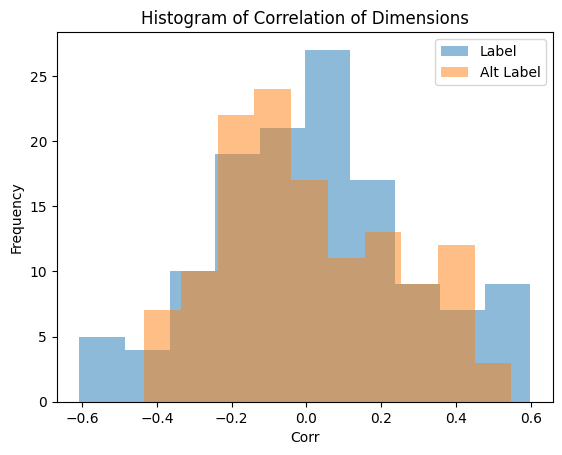

Max Corr Label 0.5988681562903855 , Max Corr Alt Label 0.5482244454480574

Top 10 Corr Label [0.59886816 0.55941821 0.55115218 0.54402599 0.5433952  0.52871933
 0.52069526 0.51768924 0.48808707 0.46045053] 
Top 10 Corr Alt Label [0.54822445 0.47418461 0.46007081 0.43732092 0.42496988 0.41557385
 0.40782031 0.40142805 0.39683998 0.39470528]


In [141]:
corr_label_dims = [scipy.stats.pearsonr(labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]
corr_alt_label_dims = [scipy.stats.pearsonr(alt_labels_train.squeeze(), interm_train.detach()[:, i]).statistic for i in range(interm_train.shape[1])]

plt.hist(corr_label_dims, alpha=0.5, label='List 1')
plt.hist(corr_alt_label_dims, alpha=0.5, label='List 2')
plt.title('Histogram of Correlation of Dimensions')
plt.xlabel('Corr')
plt.ylabel('Frequency')
plt.legend(['Label', 'Alt Label'])

plt.show()

print('Max Corr Label', max(corr_label_dims), ', Max Corr Alt Label', max(corr_alt_label_dims))
print('\nTop 10 Corr Label', torch.topk(torch.tensor(corr_label_dims), 10).values.numpy(), '\nTop 10 Corr Alt Label', torch.topk(torch.tensor(corr_alt_label_dims), 10).values.numpy())

Have some higher frequency of correlation, which is important/shows some difference potentially

In [143]:
train_size = int(0.8 * len(interm_train))

train_dataset = TensorDataset(interm_train.detach(), labels_train.view(-1, 1))
val_dataset = TensorDataset(interm_val.detach(), labels_val.view(-1, 1))

train_dataset_alt = TensorDataset(interm_train.detach(), alt_labels_train.view(-1, 1))
val_dataset_alt = TensorDataset(interm_val.detach(), alt_labels_val.view(-1, 1))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_dataloader_alt = DataLoader(train_dataset_alt, batch_size=32, shuffle=True)
val_dataloader_alt = DataLoader(val_dataset_alt, batch_size=32, shuffle=False)

probe_labels = Probe(interm_train.shape[1]).to(device)
probe_alt_labels = Probe(interm_train.shape[1]).to(device)

In [146]:
trainer = Trainer(max_epochs=epochs)
trainer.fit(probe_labels, train_dataloader, val_dataloader)
trainer.validate(probe_labels, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9664999842643738     │
│      val_loss_epoch       │    0.05521305650472641    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.05521305650472641, 'val_acc_epoch': 0.9664999842643738}]

In [147]:
trainer = Trainer(max_epochs=1)
trainer.fit(probe_alt_labels, train_dataloader_alt, val_dataloader_alt)
trainer.validate(probe_alt_labels, val_dataloader_alt)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | body | Linear | 128   
--------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.9564999938011169     │
│      val_loss_epoch       │    0.0874154269695282     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 0.0874154269695282, 'val_acc_epoch': 0.9564999938011169}]

## TRANSPLANTATION

In [ ]:
PYTHIA_VOCAB_SIZE = 50277 #50304
N_LAYERS=12
MODEL = "EleutherAI/pythia-160m"
PYTHIA_CHECKPOINTS_OLD = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512] + list(range(1000, 143000 + 1, 10000)) + [143000]
PYTHIA_CHECKPOINTS = [512] + list(range(1000, 10000 + 1, 1000))

HeadName = Literal["previous_token_head", "duplicate_token_head", "induction_head"]
HEAD_NAMES = cast(List[HeadName], get_args(HeadName))

In [ ]:
def create_repeats_dataset(num_samples=50, min_vector_size=5, max_vector_size=50, min_num_repeats=5, max_num_repeats=20, max_vocab=PYTHIA_VOCAB_SIZE):
  """Creates a dataset for the experiment."""
  dataset = []
  for _ in range(num_samples):
    vector_size = torch.randint(min_vector_size, max_vector_size, (1,)).item()
    num_repeats = torch.randint(min_num_repeats, max_num_repeats, (1,)).item()
    tokens = torch.randint(0, max_vocab, (1, vector_size))
    tokens = tokens.repeat((1, num_repeats))
    dataset.append(tokens)
  return dataset

In [ ]:
dataset = torch.load('../outputs/aheads/dataset.pt')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def copy_attention_head(model1, model2, layer_idx, head_idx, dataset):
  if model1.isinstance(HookedTransformer) and model2.isinstance(HookedTransformer):
    model1.W_K.data[layer_idx, head_idx, :, :] = model2.W_K.data[layer_idx, head_idx, :, :]
    model1.W_Q.data[layer_idx, head_idx, :, :] = model2.W_Q.data[layer_idx, head_idx, :, :]
    model1.W_V.data[layer_idx, head_idx, :, :] = model2.W_V.data[layer_idx, head_idx, :, :]
    model1.b_K.data[layer_idx, head_idx, :] = model2.b_K.data[layer_idx, head_idx, :]
    model1.b_Q.data[layer_idx, head_idx, :] = model2.b_Q.data[layer_idx, head_idx, :]
    model1.b_V.data[layer_idx, head_idx, :] = model2.b_V.data[layer_idx, head_idx, :]
  else:
    model1.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:] = model2.encoder.layers[layer_idx].self_attn.in_proj_weight.data[head_idx,:,:]
  return perplexity(model1, dataset), perplexity(model2, dataset)


In [13]:
def calculate_perplexity(corpus, model, device="cpu"):
    encoded_input = model.to_tokens(corpus)
    encoded_input = encoded_input.to(device)
    with torch.no_grad():
      outputs = model(encoded_input).squeeze(0)
      loss = F.cross_entropy(outputs, encoded_input.squeeze(0), reduction='sum')/encoded_input.shape[1]
    perplexity = torch.exp(loss).item()
    return perplexity

In [15]:
def perplexity(model, dataset):
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
  with torch.no_grad():
    for batch in data_loader:
      inputs, targets = batch
      outputs = model(inputs)
      loss = F.cross_entropy(outputs, targets, reduction='sum')
      total_loss += loss.item()
    average_loss = total_loss / len(data_loader.dataset)
    return torch.exp(torch.tensor(average_loss))

# Attn Head Figure Gen

In [224]:
import pandas as pd
import seaborn as sns

In [242]:
home = os.environ['LEARNING_DYNAMICS_HOME']

In [290]:
def make_line_graph(folder_path, layer, task, output_file):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    nrows = len(csv_files) // 3 + (len(csv_files) % 3 > 0)
    ncols = 3
    
    plt.figure(figsize=(10, 6))

    outputs = []
    for i, file in enumerate(csv_files):
        df = pd.read_csv(os.path.join(folder_path, file), delimiter='\t').drop('Layer', axis=1)
        df = df[['20', '40', '60', '80', '100', '200', '1000', '1400', '1600',
       '1800', '2000']]
        df.index = df.index[::-1]
        if 'head' in file:
            head = file.split('head_')[-1].split('.csv')[0]
            outputs.append((head, df.loc[layer].tolist()))  
            plt.plot(df.columns,  df.loc[layer].tolist(), label=f'Head {head}')
            
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title(f'{task} - Attention Layer {layer}')
    plt.xlabel('Timestep')
    plt.ylabel('Accuracy')
    legend = plt.legend(title='Legend', title_fontsize='13', fontsize='10', loc='best')

    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1.5)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    return outputs, df.columns

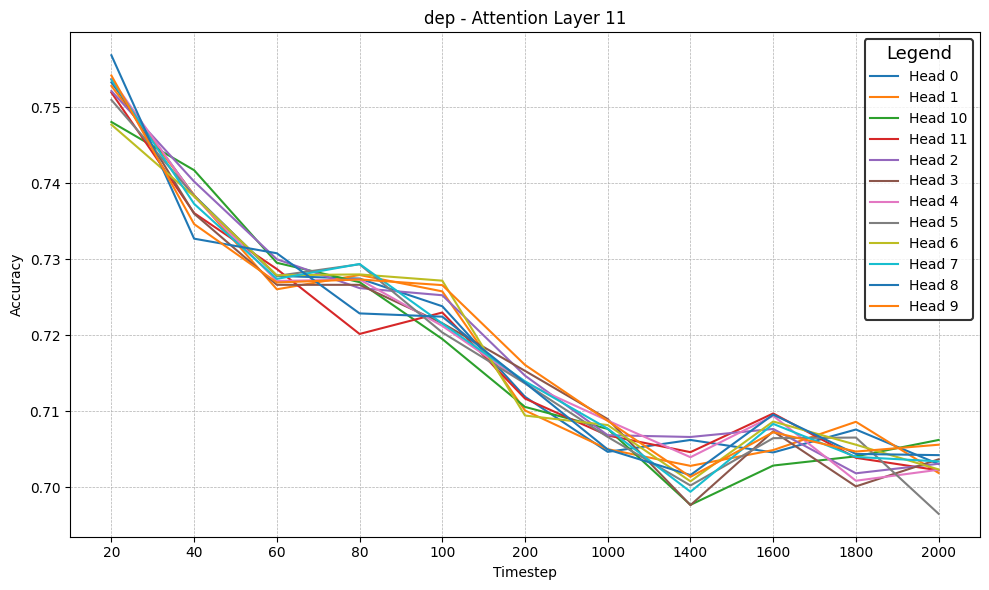

In [291]:

_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 11, 'dep', os.path.join(home, 'figures/dep_11_heads.png'))

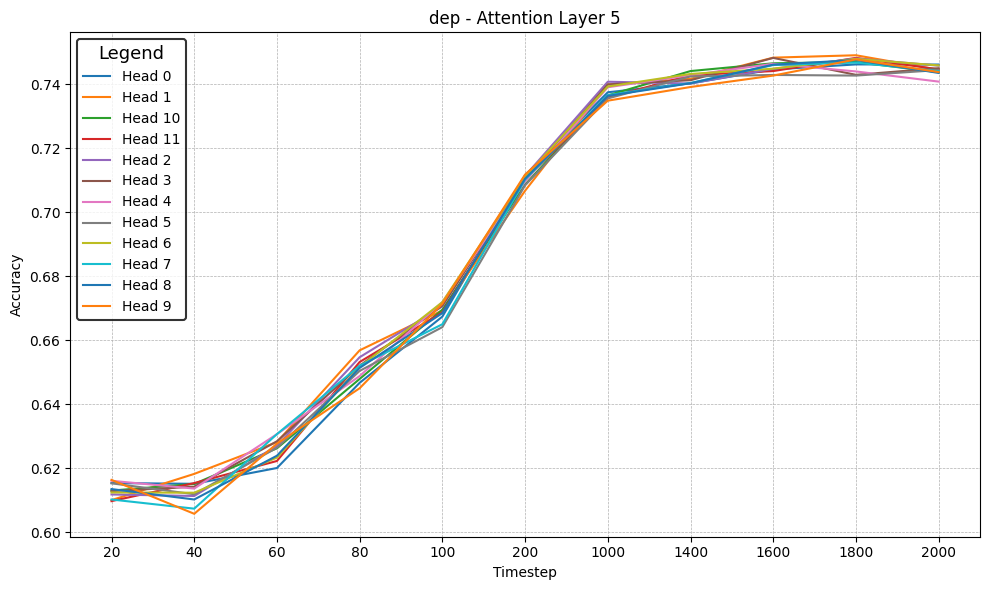

In [292]:
_ = make_line_graph(os.path.join(home, 'outputs/en_ewt-ud/dep/components'), 5, 'dep', os.path.join(home, 'figures/dep_5_heads.png'))

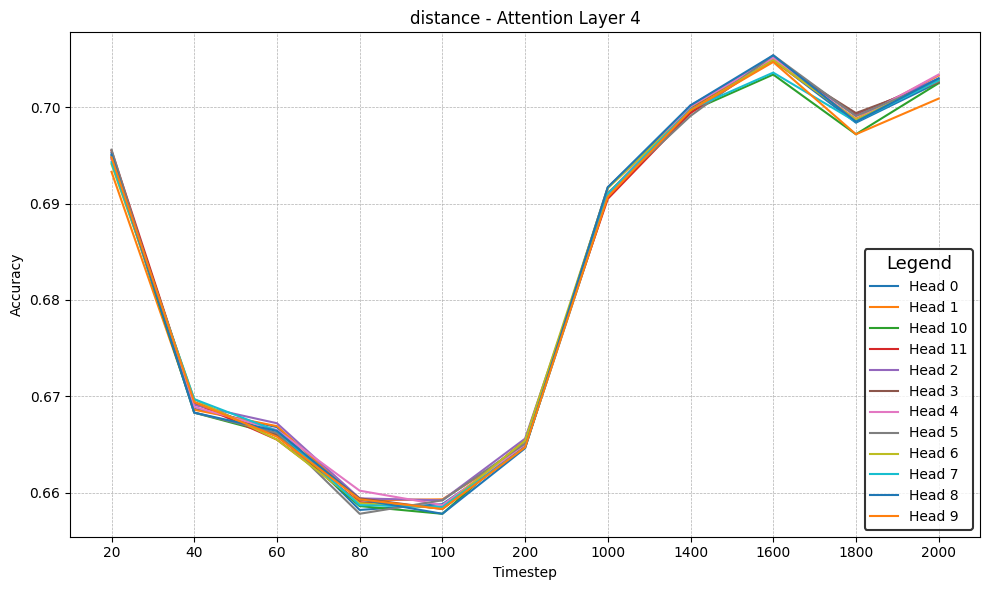

In [310]:
_ = make_line_graph(os.path.join(home, 'outputs/ptb_3/distance/components/DSpr'), 4, 'distance', os.path.join(home, 'figures/head_examples/distance_5_heads.png'))